# Rendu Fairness avec pivot de Gausse :

Dans ce notebook, nous utilisons le jeu de donnée des accidents de la route. <br>
Tout d'abord en ananlysant les données brutes.<br>
Puis en les transformant en un modèle à l'aide d'un **arbre de décision**.<br>
Pour finir, nous analysons ce modèle.

On souhaite prédire si un véhicule donné est impliqué dans un accident **mortel** ou non.

In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from utils import *

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn import preprocessing
#import imblearn

## Préparation du dataframe
Les attributs présents dans la base de données ne sont pas tous utiles et certains doivent être transformer avant d'être utilisé.

In [2]:
label = "mortal"

# Lecture datasets
df1 = pd.read_csv("dataset/usagers-2022.csv", sep=';')
df2 = pd.read_csv("dataset/lieux-2022.csv", sep=';')
df3 = pd.read_csv("dataset/carcteristiques-2022.csv", sep=';')
df4 = pd.read_csv("dataset/vehicules-2022.csv", sep=';')

df4 = df4.drop(columns=['id_vehicule', 'num_veh'])


df = df1.join(df2.set_index('Num_Acc'), on='Num_Acc')
df = df.join(df3.set_index('Accident_Id'), on='Num_Acc')
df = df.join(df4.set_index('Num_Acc'), on='Num_Acc', lsuffix='_')

/tmp/ipykernel_6512/1377824327.py:5: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_csv("dataset/lieux-2022.csv", sep=';')


In [3]:
# Suppression colonnes inutiles
df = df.drop(columns=['voie', 'v1', 'v2', 'pr', 'pr1', 'lartpc', 'larrout'
                      , 'num_veh', 'occutc', 'adr', 'senc','etatp','actp', 
                      'manv', 'jour', 'com', 'hrmn', 'motor', 'place', 'vosp', 'locp'])

df = df.drop_duplicates(subset=['id_usager']) # retire les doublons dans les usagers

# Remplacement des valeurs NaN
df['an_nais'] = df['an_nais'].fillna(df['an_nais'].mode()[0])

# Convertir en entier
df['id_vehicule'] = df['id_vehicule'].apply(lambda l: l[0:3] + l[4:7])
df['id_vehicule'] = df['id_vehicule'].astype(int)
df['sexe'] = df['sexe'].astype(int)
df

,Num_Acc,id_usager,id_vehicule,catu,grav,sexe,an_nais,trajet,secu1,secu2,...,agg,int,atm,col,lat,long,catv,obs,obsm,choc
0,202200000001,1 099 700,813952,1,3,1,2008.0,5,2,8,...,2,3,1,3,"44,5594200000","4,7257200000",2,0,2,1
1,202200000001,1 099 701,813953,1,1,1,1948.0,5,1,8,...,2,3,1,3,"44,5594200000","4,7257200000",2,0,2,1
2,202200000002,1 099 698,813950,1,4,1,1988.0,9,1,0,...,2,3,1,3,"46,9258100000","6,3462000000",7,0,2,8
3,202200000002,1 099 699,813951,1,1,1,1970.0,4,1,0,...,2,3,1,3,"46,9258100000","6,3462000000",7,0,2,8
4,202200000003,1 099 696,813948,1,1,1,2002.0,0,1,0,...,2,6,1,2,"48,4931620000","-2,7604390000",7,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126657,202200055301,968 230,715631,1,1,2,2002.0,5,1,-1,...,1,3,1,3,"43,9272650000","1,9156370000",7,0,0,8
126658,202200055301,968 231,715631,2,3,2,2004.0,5,1,-1,...,1,3,1,3,"43,9272650000","1,9156370000",7,0,0,8
126659,202200055301,968 232,715632,1,4,2,1953.0,5,1,-1,...,1,3,1,3,"43,9272650000","1,9156370000",7,0,0,8
126660,202200055302,968 228,715629,1,3,1,1992.0,1,2,6,...,2,1,1,2,"47,5944040000","1,3533290000",33,0,2,1


In [4]:
for column in df.columns:
  if df[column].isnull().values.any() == True:
    print(column, df[column].isnull().values.any()) # afficher s'il y a des valeurs nulles

In [5]:
df_2 = df.copy()

# On crée un attribut pour les accidents mortels
df_2['mortal'] = extract_mortal(df)

# Accident impliquant un piéton
has_pedestrian = df[df['catu'] == 3]
p = to_attribute(df, has_pedestrian, 1, 0)
df_2['pieton'] = p

# Sexe du conducteur
driver = df[(df['catu'] == 1) & (df['sexe'] == 1)]
dr = to_attribute(df, driver, 1, 0)
df_2['sexe_conducteur'] = dr


df_2 = df_2.drop_duplicates(subset=['id_vehicule'])

Pour simplifier le code, les fonction qui uniformisent les types vers ceux souhaités ont été plcées dans **utils.py**

In [6]:
# On réduit les carégories de véhicules
df_2 = simplify_catv(df_2)

# On enlève la catégorie peu repésentées qu'on ajoute dans une catégorie autre (identifiant 5)
df_2 = simplify_catr(df_2)

# Découpage en 4 catégories de vitesse
df_2 = split_vma(df_2)

        
# Département en entiers
df_2['dep'] = df_2['dep'].apply(transforme_dpt)
df_2['dep'] = pd.to_numeric(df_2['dep'], errors='coerce', downcast='integer')

# nbv en entier
df_2['nbv'] = pd.to_numeric(df_2['nbv'], errors='coerce', downcast='integer')
df_2['nbv'].fillna(2, inplace=True) # only one entry 
df_2['nbv'] = pd.to_numeric(df_2['nbv'], errors='coerce', downcast='integer')

# Lat et long en float :
df_2['lat'] = pd.to_numeric(df_2['lat'], errors='coerce')
df_2['long'] = pd.to_numeric(df_2['long'], errors='coerce')

# Age du conducteur du véhicule
df_2['age'] = get_driver_age(df_2)
df_2['age'] = df_2['age'].fillna(df_2['age'].mode()[0])
df_2['age'] = pd.to_numeric(df_2['age'], errors='coerce', downcast='integer')

# Réduire les valeurs de trajet
df_2['trajet'] = reduce_trajet_values(df_2)

# Réduire les valeurs de surf
df_2['surf'] = reduce_surf_values(df_2)

# obs prend pour valeur 0 si obstacle 1 si pas d'obstacle
df_2['obs'] = reduce_obs_values(df_2)

# On enlève les attributs qui ne sont plus utiles
df_2 = df_2.drop(columns=['an_nais','grav', 'sexe','catu', 'id_usager', 'id_vehicule',
                          'secu1','secu2','secu3', 'an', 'lat', 'long'])

Tri manuel des valeurs catégorielles/numériques

In [7]:
# valeurs catégorielles
categorical_features = ['trajet', 'catr', 'circ', 'nbv', 'prof',
                        'plan', 'surf', 'vma', 'lum', 'agg', 
                        'int', 'atm', 'col', 'catv', 'obs', 'obsm', 'choc', 'pieton',
                        'sexe_conducteur', 'infra', 'situ']
# valeurs numériques
numerical_features = ['mois', 'dep','age']

print("numerical : ", numerical_features)
print("categorical : ", categorical_features)

numerical :  ['mois', 'dep', 'age']
categorical :  ['trajet', 'catr', 'circ', 'nbv', 'prof', 'plan', 'surf', 'vma', 'lum', 'agg', 'int', 'atm', 'col', 'catv', 'obs', 'obsm', 'choc', 'pieton', 'sexe_conducteur', 'infra', 'situ']


## Analyse de données
**Attention** conserver les sorties alourdit grandement le notebook, **clear all outputs** avant d'enregistrer est à privilégier.

### Analyse univariée

In [8]:
val = [len(df_2[df_2.mortal == 1]), len(df_2[df_2.mortal == 0])]
labels = ['Accident mortel', 'Accident non mortel']
px.pie(values=val, names=labels)

In [9]:
val = [len(df_2[df_2.pieton == 1]), len(df_2[df_2.pieton == 0])]
labels = ['Implique piéton', 'N\'implique pas de piéton']
px.pie(values=val, names=labels)

In [ ]:
fig = px.histogram(df_2, x="catv")
fig.show()

fig = px.box(df_2, x="age")
fig.show()

fig = px.histogram(df_2, x="sexe_conducteur")
fig.show()

fig = px.histogram(df_2, x="catr")
fig.show()

fig = px.histogram(df_2, x="col")
fig.show()

fig = px.histogram(df_2, x='obs')
fig.show()

### Analyse bivariée

In [ ]:
features = ['age', 'mois', 'catr', 'mortal', 'sexe_conducteur', 'col']

for exp in features:
    print(exp)
    analyse_bi_quali_quanti("catv", exp, df_2)

In [ ]:
features = ['age', 'mois', 'catr', 'mortal', 'col']

for exp in features:
    print(exp)
    analyse_bi_quali_quanti("vma", exp, df_2)

In [ ]:
features = ['age', 'vma', 'mois', 'catr', 'mortal']

for exp in features:
    print(exp)
    analyse_bi_quali_quanti("col", exp, df_2)

In [ ]:
features = ['age', 'vma', 'mois', 'catr', 'mortal']

interet = "pieton"

for exp in categorical_features:
    if exp==interet:
        continue
    print(exp)
    analyse_bi_quali_quali(interet, exp, df_2, numerical_features)

In [ ]:
interet = "obs"

for exp in categorical_features:
    if exp==interet:
        continue
    print(exp)
    analyse_bi_quali_quali(interet, exp, df_2, numerical_features)

In [ ]:
interet = "sexe_conducteur"

for exp in categorical_features:
    if exp==interet:
        continue
    print(exp)
    analyse_bi_quali_quali(interet, exp, df_2, numerical_features)

## One hot encoding

In [10]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

transformations = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])

## Apprentissage avec un arbre de décision

In [11]:
from sklearn.model_selection import train_test_split

# On découpe le jeu de données tout en conservant ensemble les véhicules impliqué dans un même accident
# Les données d'entrainement et de test n'ont donc pas de rapport direct

unique_accidents = df_2['Num_Acc'].unique() # Num_Acc uniques

df_3 = df_2.drop(columns=['mortal'])
# Création des train et test set à partir des numéros d'accident
X_train, X_test = train_test_split(unique_accidents, test_size=0.33, random_state=42)

# On peut ensuite récupérer les véhicules correspondants aux accidents
train_df = df_2[df_2['Num_Acc'].isin(X_train)]
test_df = df_2[df_2['Num_Acc'].isin(X_test)]
y_train = train_df['mortal']
y_test = test_df['mortal']
X_train = train_df.drop(columns=['mortal', 'Num_Acc'])
X_test = test_df.drop(columns=['mortal', 'Num_Acc'])
df_2 = df_2.drop(columns='Num_Acc')

In [12]:
from sklearn import tree, ensemble, naive_bayes

dt = tree.DecisionTreeClassifier(random_state=42)
clf = Pipeline(steps=[('preprocessor', transformations),
                      ('classifier', dt)])
clf = clf.fit(X_train, y_train)

preds = clf.predict(X_test)

clf.score(X_train, y_train), clf.score(X_test, y_test)

(1.0, 0.9013821321563195)

### Afficher la matrice de confusion

In [13]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
tn, fp, fn, tp

(27687, 1648, 1413, 291)

In [14]:
import plotly.express as px

fig = px.imshow([[tn, fp], [fn, tp]], text_auto=True, labels=dict(y="Truth", x="Pred"),
                x=["False", "True"],
                y=["False", "True"]
               )
fig.show()

### Les métriques "Base rate"

In [36]:
encoders = {cat_col:preprocessing.LabelEncoder() for cat_col in categorical_features}

for cat_col in categorical_features:
  df_2[cat_col] = encoders[cat_col].fit_transform(df_2[cat_col])
  print(cat_col)
  for idx in sorted(df_2[cat_col].unique()):
    print(idx, encoders[cat_col].inverse_transform([idx]))

trajet
0 [0]
1 [1]
2 [2]
3 [3]
4 [4]
5 [5]
catr
0 [1]
1 [2]
2 [3]
3 [4]
4 [5]
circ
0 [-1]
1 [1]
2 [2]
3 [3]
4 [4]
nbv
0 [-1]
1 [0]
2 [1]
3 [2]
4 [3]
5 [4]
6 [5]
7 [6]
8 [7]
9 [8]
10 [9]
11 [10]
12 [11]
13 [12]
prof
0 [-1]
1 [1]
2 [2]
3 [3]
4 [4]
plan
0 [-1]
1 [1]
2 [2]
3 [3]
4 [4]
surf
0 [0]
1 [1]
2 [2]
3 [3]
4 [4]
5 [5]
6 [6]
7 [7]
8 [8]
vma
0 [1]
1 [2]
2 [3]
3 [4]
lum
0 [-1]
1 [1]
2 [2]
3 [3]
4 [4]
5 [5]
agg
0 [1]
1 [2]
int
0 [-1]
1 [1]
2 [2]
3 [3]
4 [4]
5 [5]
6 [6]
7 [7]
8 [8]
9 [9]
atm
0 [-1]
1 [1]
2 [2]
3 [3]
4 [4]
5 [5]
6 [6]
7 [7]
8 [8]
9 [9]
col
0 [-1]
1 [1]
2 [2]
3 [3]
4 [4]
5 [5]
6 [6]
7 [7]
catv
0 [0]
1 [1]
2 [2]
3 [3]
4 [4]
5 [5]
obs
0 [0]
1 [1]
obsm
0 [-1]
1 [0]
2 [1]
3 [2]
4 [4]
5 [5]
6 [6]
7 [9]
choc
0 [-1]
1 [0]
2 [1]
3 [2]
4 [3]
5 [4]
6 [5]
7 [6]
8 [7]
9 [8]
10 [9]
pieton
0 [0]
1 [1]
sexe_conducteur
0 [0]
1 [1]
infra
0 [-1]
1 [0]
2 [1]
3 [2]
4 [3]
5 [4]
6 [5]
7 [6]
8 [7]
9 [8]
10 [9]
situ
0 [-1]
1 [1]
2 [2]
3 [3]
4 [4]
5 [5]
6 [6]
7 [8]


In [37]:
def compute_stat(preds, sensitive, value=None, not_value=None):
    if value is not None:
      preds_sel = preds[sensitive == value]
    elif not_value is not None:
      preds_sel = preds[sensitive != not_value]
    else:
      print("one of 'value' and 'not value' must be set")
      return None, None, None, None
    card = len(preds_sel)
    card_pos = len(preds_sel[preds_sel == 1])
    card_neg = len(preds_sel[preds_sel == 0])
    return card, card_pos, card_neg, preds_sel


def compute_baserate(preds, sensitive=X_test["sexe_conducteur"], value=0):

    n_F, n_F_pos, n_F_neg, preds_F = compute_stat(preds=preds, sensitive=sensitive, value=value)
    n_M, n_M_pos, n_M_neg, preds_M = compute_stat(preds=preds, sensitive=sensitive, not_value=value)

    DI = n_F_pos/n_F*n_M/n_M_pos
    p_DI = np.min([DI, 1/DI])
    DP = n_F_pos/n_F - n_M_pos/n_M

    ret = {}
    ret["disparate_impact"] = DI
    ret["P_rule_disparate_impact"] = p_DI
    ret["demography_parity"] = DP

    return ret

In [39]:
preds = clf.predict(X_test)
for att,unpriv in zip(['sexe_conducteur', 'pieton'],[1, 1]):
  value = encoders[att].transform([unpriv])[0]
  base_rate_pred = compute_baserate(preds, sensitive=X_test[att], value=value)
  base_rate_label = compute_baserate(y_test, sensitive=X_test[att], value=value)
  print(att, unpriv)
  for k,v in base_rate_pred.items():
    print(k, v, base_rate_label[k])

sexe_conducteur 1
disparate_impact 1.21767750298587 1.6331199049428085
P_rule_disparate_impact 0.8212355057458954 0.6123249107266375
demography_parity 0.011747835864606336 0.02383701239031672
pieton 1
disparate_impact 1.0538191011165416 1.0968113720110815
P_rule_disparate_impact 0.9489294689576994 0.9117337999207913
demography_parity 0.003345154811069756 0.005266913173450724


## Audit du modèle

In [15]:
import pickle

data_test = X_test.copy(deep=True)
data_test["Y"] = y_test

data_test.to_csv("test_data.csv",
          index=False)

data_train = X_train.copy(deep=True)
data_train["Y"] = y_train

data_train.to_csv("train_data.csv",
          index=False)

with open( 'clf.pickle', 'wb' ) as f:
    pickle.dump(clf, f )

### Trouver des contrefactuels avec Dice

In [35]:
import dice_ml
from dice_ml.utils import helpers
from IPython.core.display import HTML

In [36]:
train_dataset = df_2.copy()
train_dataset[label] = y_train
d = dice_ml.Data(dataframe=train_dataset, continuous_features=numerical_features, outcome_name=label)

m = dice_ml.Model(model=clf, backend="sklearn")

exp = dice_ml.Dice(d, m)

In [37]:
# Génération des contrefactuels
for i in range(5):
  query_instance = data_test.drop(columns="Y")[i:i+1]
  dice_exp = exp.generate_counterfactuals(
      query_instance,
      total_CFs=10,
      desired_class="opposite")
  # Visualize counterfactual explanation
  dice_exp.visualize_as_dataframe(show_only_changes=True)
  # Instance local feature importance
  pd.set_option("display.max_rows", None, "display.max_columns", None)
  imp = exp.local_feature_importance(query_instance, cf_examples_list=dice_exp.cf_examples_list)
  print(imp.local_importance)

100%|██████████| 1/1 [00:00<00:00,  4.43it/s]

Query instance (original outcome : 0)


,trajet,catr,circ,nbv,prof,plan,surf,infra,situ,vma,...,atm,col,catv,obs,obsm,choc,pieton,sexe_conducteur,age,mortal
0,0,4,2,2,1,1,1,0,1,2,...,1,3,3,0,2,8,0,1,34,0



Diverse Counterfactual set (new outcome: 1)


,trajet,catr,circ,nbv,prof,plan,surf,infra,situ,vma,...,atm,col,catv,obs,obsm,choc,pieton,sexe_conducteur,age,mortal
0,-,-,-,-,-,-,-,-,-,-,...,-,-,5,-,-1,-,1,-,37,1
1,-,-,-,-,-,-,-,-,5,-,...,-,-,1,-,9,-,-,-,99,1
2,-,-,-,-,-,-,-,-,3,-,...,6,-,-,-,-1,-,-,-,98,1
3,-,-,-,-,-,-,-,1,-,-,...,-,-,-,-,-,-,-,-,-,1
4,-,1,-,-,-,-,2,-,-,-,...,-,-,-,-,1,-,1,-,62,1
5,-,-,-,-,-,-,-,-,3,-,...,-,-,-,-,9,-,-,0,100,1
6,-,-,-,-,-,-,-,-,3,-,...,-,-,-,-,9,-,-,-,100,1
7,-,-,-,-,-,-,4,-,-,-,...,-,-,-,-,4,-,-,-,63,1
8,-,-,-,-,-,-,-,-,5,-,...,-,-,1,-,9,-,-,-,99,1
9,-,-,-,-,-,-,2,-,-,-,...,-,-,-,-,1,-,1,-,62,1


[{'obsm': 0.9, 'age': 0.9, 'situ': 0.5, 'surf': 0.3, 'catv': 0.3, 'pieton': 0.3, 'mois': 0.2, 'catr': 0.1, 'infra': 0.1, 'lum': 0.1, 'atm': 0.1, 'sexe_conducteur': 0.1, 'dep': 0.1, 'trajet': 0.0, 'circ': 0.0, 'nbv': 0.0, 'prof': 0.0, 'plan': 0.0, 'vma': 0.0, 'agg': 0.0, 'int': 0.0, 'col': 0.0, 'obs': 0.0, 'choc': 0.0}]


100%|██████████| 1/1 [00:00<00:00,  4.41it/s]

Query instance (original outcome : 0)


,trajet,catr,circ,nbv,prof,plan,surf,infra,situ,vma,mois,lum,dep,agg,int,atm,col,catv,obs,obsm,choc,pieton,sexe_conducteur,age,mortal
0,4,4,2,2,1,1,1,0,1,2,10,1,25,2,3,1,3,3,0,2,8,0,1,52,0



Diverse Counterfactual set (new outcome: 1)


,trajet,catr,circ,nbv,prof,plan,surf,infra,situ,vma,mois,lum,dep,agg,int,atm,col,catv,obs,obsm,choc,pieton,sexe_conducteur,age,mortal
0,-,-,4,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,5,-,-,-,-,1
1,-,-,4,-,-1,-,-,-,-,-,-,-,-,-,-,-,-,-,-,5,-,1,-,-,1
2,-,-,-,-,-,-,-,-,8,-,-,-,-,-,-,9,-,-,-,-,-,-,-,81,1
3,-,-,-,-,-,-,-,-,-1,-,-,-,-,-,-,-,-,-,-,1,7,-,-,83,1
4,-,-,-,-,-,-,-,-,5,-,-,-,-,-,-,-,-,-,-,-,1,-,-,62,1
5,-,-,1,-,-,3,-,-,-,-,-,-,-,-,-,-,-,-,-,9,-,-,-,-,1
6,-,-,-1,-,-,-,-,-,-,-,-,3,-,1,-,-,-,2,-,0,-,-,-,-,1
7,-,-,1,-,-,2,-,-,-,-,-,-,-,1,-,-,-,-,-,0,-,-,-,-,1
8,-,-,1,-,-,-,3,-,4,-,-,-,-,-,-,-,-,-,-,5,-,-,-,76,1
9,-,-,4,-,-1,-,-,-,-,-,-,-,-,-,-,-,-,-,-,5,-,-,-,-,1


[{'obsm': 0.8, 'circ': 0.7, 'situ': 0.4, 'age': 0.4, 'prof': 0.2, 'plan': 0.2, 'agg': 0.2, 'choc': 0.2, 'surf': 0.1, 'lum': 0.1, 'atm': 0.1, 'catv': 0.1, 'pieton': 0.1, 'trajet': 0.0, 'catr': 0.0, 'nbv': 0.0, 'infra': 0.0, 'vma': 0.0, 'int': 0.0, 'col': 0.0, 'obs': 0.0, 'sexe_conducteur': 0.0, 'mois': 0.0, 'dep': 0.0}]


100%|██████████| 1/1 [00:00<00:00,  4.76it/s]

Query instance (original outcome : 0)


,trajet,catr,circ,nbv,prof,plan,surf,infra,situ,vma,mois,lum,dep,agg,int,atm,col,catv,obs,obsm,choc,pieton,sexe_conducteur,age,mortal
0,0,3,2,2,1,1,1,0,1,3,10,1,13,1,1,1,2,3,0,2,4,0,0,47,0



Diverse Counterfactual set (new outcome: 1)


,trajet,catr,circ,nbv,prof,plan,surf,infra,situ,vma,mois,lum,dep,agg,int,atm,col,catv,obs,obsm,choc,pieton,sexe_conducteur,age,mortal
0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,81,1
1,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,4,-,-,-,-,-,-,12,1
2,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,6,1
3,-,-,-,-,-,-,-,4,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,14,1
4,-,-,-,-,-,-,-,2,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,81,1
5,-,-,-,-,-,-,-,-,-,-,-,-,979,-,-,-,-,-,1,-,-,-,-,-,1
6,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,12,1
7,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,1,-,-,-,-,4,1
8,-,-,-,-,-,-,-,-,-,-,-,-,-,-,5,-,-,-,-,-,-,-,-,94,1
9,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,4,1


[{'age': 0.9, 'infra': 0.2, 'obs': 0.2, 'int': 0.1, 'col': 0.1, 'dep': 0.1, 'trajet': 0.0, 'catr': 0.0, 'circ': 0.0, 'nbv': 0.0, 'prof': 0.0, 'plan': 0.0, 'surf': 0.0, 'situ': 0.0, 'vma': 0.0, 'lum': 0.0, 'agg': 0.0, 'atm': 0.0, 'catv': 0.0, 'obsm': 0.0, 'choc': 0.0, 'pieton': 0.0, 'sexe_conducteur': 0.0, 'mois': 0.0}]


100%|██████████| 1/1 [00:00<00:00,  6.05it/s]

Query instance (original outcome : 0)


,trajet,catr,circ,nbv,prof,plan,surf,infra,situ,vma,mois,lum,dep,agg,int,atm,col,catv,obs,obsm,choc,pieton,sexe_conducteur,age,mortal
0,0,3,2,2,1,1,1,0,1,3,10,1,13,1,1,1,2,3,0,2,4,0,0,26,0



Diverse Counterfactual set (new outcome: 1)


,trajet,catr,circ,nbv,prof,plan,surf,infra,situ,vma,mois,lum,dep,agg,int,atm,col,catv,obs,obsm,choc,pieton,sexe_conducteur,age,mortal
0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,2,1
1,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,3,1
2,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,15,1
3,-,-,-,-,-1,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,75,1
4,-,-,-,-,-,-,-,-,-,-,-,-,980,-,-,-,-,-,-,-,-,-,-,-,1
5,-,-,-,-,-,-,-,8,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,6,1
6,-,-,-,-,-,-,-,-,-,1,-,-,-,-,-,-,-,-,-,-,-,-,-,14,1
7,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,11,1
8,1,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,4,1
9,-,-,-,-,-,-,-,-,-,-,-,-,980,-,-,-,-,-,-,-,-,-,-,-,1


[{'age': 0.8, 'dep': 0.2, 'trajet': 0.1, 'prof': 0.1, 'infra': 0.1, 'vma': 0.1, 'catr': 0.0, 'circ': 0.0, 'nbv': 0.0, 'plan': 0.0, 'surf': 0.0, 'situ': 0.0, 'lum': 0.0, 'agg': 0.0, 'int': 0.0, 'atm': 0.0, 'col': 0.0, 'catv': 0.0, 'obs': 0.0, 'obsm': 0.0, 'choc': 0.0, 'pieton': 0.0, 'sexe_conducteur': 0.0, 'mois': 0.0}]


100%|██████████| 1/1 [00:00<00:00,  4.22it/s]

Query instance (original outcome : 0)


,trajet,catr,circ,nbv,prof,plan,surf,infra,situ,vma,mois,lum,dep,agg,int,atm,col,catv,obs,obsm,choc,pieton,sexe_conducteur,age,mortal
0,0,4,1,1,1,1,1,0,1,2,10,5,13,2,1,1,1,3,0,2,1,0,1,37,0



Diverse Counterfactual set (new outcome: 1)


,trajet,catr,circ,nbv,prof,plan,surf,infra,situ,vma,mois,lum,dep,agg,int,atm,col,catv,obs,obsm,choc,pieton,sexe_conducteur,age,mortal
0,-,-,4,-,-,-,3,-,-,-,-,-,-,-,-,-,-,-,-,5,-,-,-,81,1
1,-,-,-,-,-,-,-,-,-,-,-,-,479,1,-,-,-,-,-,-,-,-,-,83,1
2,-,-,-,-,-,-,-,-,-,-,-,-,846,-,-1,-,-,-,-,-,-,-,-,-,1
3,-,-,4,-,-,-,-,-,-,-,-,-,-,-,-,5,-,5,-,1,-,-,-,88,1
4,-,-,-,-,-,-,-,-,-,-,-,-,479,1,-,-,-,-,-,-,-,-,-,83,1
5,-,-,-,-,-1,-,-,-,-,-,-,-,805,-,-,-,-,-,-,-,-,-,0,-,1
6,1,2,-,-,-1,-,-,-,-,-,-,-,408,1,-,-,-,-,-,-,-,-,-,-,1
7,-,-,-,-,-,-,-,-,-,-,4,1,-,-,-,-,-,-,-,-,-,-,-,-,1
8,-,-,-,-,2,-,-,3,-,-,-,-,459,-,-,-,-,-,-,-,-,-,-,-,1
9,-,1,-,-,-,-,4,-,-,-,3,1,-,-,-,-,-,-,-,-,-,-,-,-,1


[{'dep': 0.6, 'age': 0.4, 'prof': 0.3, 'agg': 0.3, 'catr': 0.2, 'circ': 0.2, 'surf': 0.2, 'lum': 0.2, 'obsm': 0.2, 'mois': 0.2, 'trajet': 0.1, 'infra': 0.1, 'int': 0.1, 'atm': 0.1, 'catv': 0.1, 'sexe_conducteur': 0.1, 'nbv': 0.0, 'plan': 0.0, 'situ': 0.0, 'vma': 0.0, 'col': 0.0, 'obs': 0.0, 'choc': 0.0, 'pieton': 0.0}]


### BlackBoxAuditing

In [ ]:
from BlackBoxAuditing.data import load_from_file
from BlackBoxAuditing.model_factories.AbstractModelFactory import AbstractModelFactory
from BlackBoxAuditing.model_factories.AbstractModelVisitor import AbstractModelVisitor

import BlackBoxAuditing as BBA


(_, train_BBA, _, _, _, _) = load_from_file("train_data.csv",
                      correct_types = np.repeat([int], [len(data_test.columns)]),
                                response_header = 'Y',
                               train_percentage = 1.0)
(headers, _, test_BBA, response_header, features_to_ignore, correct_types) = load_from_file("test_data.csv",
                      correct_types = np.repeat([int], [len(data_test.columns)]),
                                response_header = 'Y',
                               train_percentage = 0.0)
BBA_data = (headers, train_BBA, test_BBA, response_header, features_to_ignore, correct_types)

In [ ]:
class HirePredictorBuilder(AbstractModelFactory):
    def __init__(self, *args, **kwargs):
        AbstractModelFactory.__init__(self, *args, **kwargs)
        self.verbose_factory_name = "HirePredictor"
    def build(self, train_set):
        return HirePredictor()

class HirePredictor(AbstractModelVisitor):
    def __init__(self):
        with open( 'clf.pickle', 'rb' ) as f:
            self.clf = pickle.load(f)

    def test(self, test_set, test_name=""):
        df_test = pd.DataFrame(
            test_set, columns =data_test.columns.to_list())
        targets = df_test['Y']
        preds = self.clf.predict(df_test.drop('Y', axis=1))
        return [[a,b] for (a,b) in zip(targets, preds)]

In [ ]:
auditor = BBA.Auditor()
auditor.ModelFactory = HirePredictorBuilder
auditor(BBA_data, output_dir = "audit-output")

## Interprétation du modèle

### Interprétation avec ShapKit

In [18]:
cols = data_test.columns.to_list()
cols.remove('Y')
cols

['trajet',
 'catr',
 'circ',
 'nbv',
 'prof',
 'plan',
 'surf',
 'infra',
 'situ',
 'vma',
 'mois',
 'lum',
 'dep',
 'agg',
 'int',
 'atm',
 'col',
 'catv',
 'obs',
 'obsm',
 'choc',
 'pieton',
 'sexe_conducteur',
 'age']

In [19]:
def predictproba_fn(data, clf=clf, columns=cols):
  df_test = pd.DataFrame(
            [data], columns=columns )
  preds = clf.predict_proba(df_test)
  return np.squeeze(preds, axis=0)
fc = lambda x: predictproba_fn(x)[1]

In [20]:
query_instance = data_test.drop(columns="Y")[0:1]
x_class = int(clf.predict(query_instance))
query_instance=query_instance.squeeze()
print(query_instance)
print()
print("Prediction for x: {0:.0f}".format(x_class))

trajet              0
catr                4
circ                2
nbv                 2
prof                1
plan                1
surf                1
infra               0
situ                1
vma                 2
mois               10
lum                 1
dep                25
agg                 2
int                 3
atm                 1
col                 3
catv                3
obs                 0
obsm                2
choc                8
pieton              0
sexe_conducteur     1
age                34
Name: 2, dtype: int64

Prediction for x: 0


/tmp/ipykernel_6512/533814558.py:2: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



In [21]:
fc(query_instance.values)

0.0

In [22]:
X_opposite_class = X_train[clf.predict(X_train) != x_class].copy()
reference = X_opposite_class.sample()
ref_class = int(clf.predict(reference))
reference=reference.squeeze()
print(reference)
print()
print("Prediction for this reference: {0:.0f}".format(ref_class))

trajet              5
catr                3
circ                1
nbv                 2
prof                2
plan                1
surf                1
infra               0
situ                1
vma                 3
mois                1
lum                 1
dep                 6
agg                 1
int                 1
atm                 1
col                 2
catv                3
obs                 0
obsm                0
choc                6
pieton              0
sexe_conducteur     1
age                19
Name: 117488, dtype: int64

Prediction for this reference: 1


/tmp/ipykernel_6512/2782652181.py:3: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



In [23]:
fc(reference.values)

1.0

In [29]:
from shapkit.shapley_values import ShapleyValues
from shapkit.inspector import inspector
from shapkit.monte_carlo_shapley import MonteCarloShapley, MonteCarloShapleyBatch
from shapkit.sgd_shapley import SGDshapley
from shapkit.plots import plot_shapley

true_shap = MonteCarloShapley(x=query_instance, fc=fc, ref=reference, n_iter=1000)

new dimension 13


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [01:54<00:00,  8.72it/s]


In [31]:
true_shap

trajet            -0.209
catr              -0.005
circ              -0.195
nbv                0.000
prof               0.006
plan               0.000
surf               0.000
infra              0.000
situ               0.000
vma                0.000
mois              -0.187
lum                0.000
dep               -0.004
agg               -0.198
int               -0.004
atm                0.000
col                0.010
catv               0.000
obs                0.000
obsm              -0.175
choc               0.004
pieton             0.000
sexe_conducteur    0.000
age               -0.043
dtype: float64

/home/erwan/.local/lib/python3.10/site-packages/shapkit/plots.py:58: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

/home/erwan/.local/lib/python3.10/site-packages/shapkit/plots.py:72: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

/home/erwan/.local/lib/python3.10/site-packages/shapkit/plots.py:104: UserWarning:

FixedFormatter should only be used together with FixedLocator



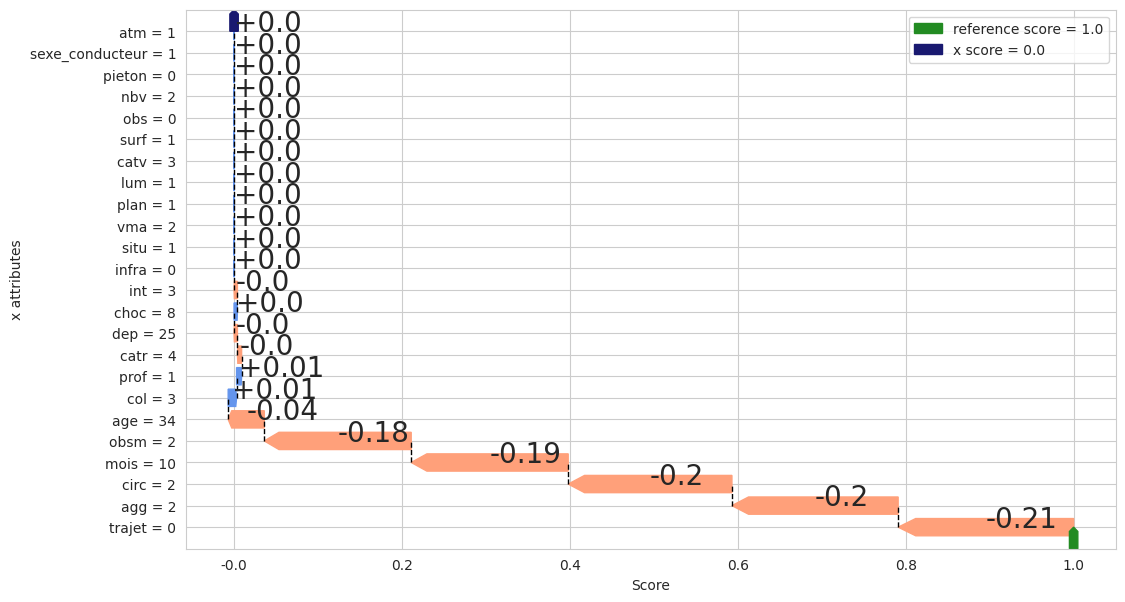

In [32]:
fig =  plot_shapley(x=query_instance, fc=fc, ref=reference, shapley_values=true_shap, n_attributes=24)